# <center> Finance Machine Learning: Meta-Labeling Application </center>

<center> <b>Renan Delgado Camurça Lima </b> <br>
June 30 2023 <br>
renandcl@ita.br <br> </center>

## Introduction

### Overview

In this material you will find a brief introduction to the Meta-Labeling application.
By the end of this tutorial, you will be able to:

- Execute a feature engineering and comprehend chronologically sampling the time series.

- Apply labeling techniques with Bollinger Bands, MADC and Triple Barrier Method.

- Understand the Meta-Labeling application and its advantages.

### Context

Recent researches started to use artificial intelligence and machine learning 
techniques in asset pricing and market trend forecasting to increase investment 
profitability [[1]](#1). Nevertheless, the use of machine learning techniques in
 financial markets is still a challenge, due to variables complexity and noise 
 signals, and strategies have been developed to deal with this problem, such as
  the use of labeling techniques, which are used to identify the trading 
  opportunities in the data [[2]](#2).

In addition to the labeling techniques, the use of meta-labeling techniques is
also a powerful to improve the performance of machine learning models.
Meta-labeling is a technique that uses the output of a primary model to generate
a new label for the data, which is used to train a secondary model [[3]](#3).
This technique seeks to maximize the model's recall (capturing correctly all positive
trading opportunities) as well as its precision (minimizing the false positive
rate)[[4]](#4).

### Objective

This work aims to analyze the chronological sampling statistical characteristics, the
performance of some labeling techniques in the stock market, and investigate the 
potential benefit of meta-learning techniques when combined with these techniques.

## Feature Engineering

Feature engineering is the process of transforming raw data into features that
better represent the underlying problem to the predictive models, resulting in
improved model accuracy on unseen data. On financial markets, the data is usually
time series that represent the price stock and aggregated into bars which 
represents its volatility on a given period of time.

Although the labeling techniques aggregate information to the data, some pitfall can 
occur depending on the technique on chronological sampling [[3]](#3). Normally, the
time bars are, nonetheless, market do don process information at a constant
interval [[4]](#4).

Moreover, time bars generally exhibit poor statistical properties. To mitigate it,
it can be applied some other strategy, as volume and dollar bars, which tend to
exhibit more stable sampling and its returns are more normally distributed [[5]](#5).

On this analysis, we will use the following features:

- **Close**: The adjusted closing price of the stock.
- **Volume**: The number of shares traded in a day.
- **Label**: Labels generated by the labeling techniques long or short positions.

### Time Series Data

The data used in this example is from a company listed on the US stock market. On
this exploratory process, IBM stocks has been selected for data comprehensions purpose.

In [43]:
import pandas as pd

# Read data
data = pd.read_csv(f"../../data/data.csv")
data.head()

,date,open,low,high,close,adj_close,volume,shares_outstanding
0,2002-12-31,73.71,73.71,75.01,74.09,42.94,8233484,1.804664e+09
1,2003-01-02,75.33,74.75,77.03,77.03,44.64,8226267,1.804664e+09
2,2003-01-03,77.15,76.68,78.06,78.06,45.24,6236566,1.804664e+09
3,2003-01-06,78.30,78.21,81.07,79.91,46.32,8285680,1.804664e+09
4,2003-01-07,80.26,80.07,82.39,82.22,47.65,12454617,1.804664e+09


Plotting the time series for the adjusted close values and volume traded:


<Axes: ylabel='Volume'>

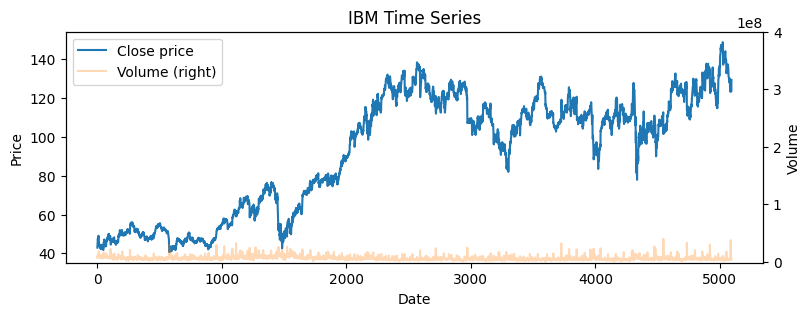

In [44]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))

data["adj_close"].plot(
    legend=True,
    title="IBM Time Series",
    xlabel="Date",
    ylabel="Price",
    label="Close price",
)

data["volume"].plot(
    secondary_y=True,
    alpha=0.3,
    yticks=np.arange(0, 5e8, 1e8),  # type: ignore
    legend=True,
    label="Volume",
    ylabel="Volume",
)

### Chronological Sampling

The aggregation on bars have some advantages, such as the reduction of the noise on 
the data, and the reduction of the computational cost. However, it can also have 
some disadvantages, such as the loss of information, and the loss of the 
chronological order [[5]](#5).

Therefore, it will be performed a comparison between on common aggregation
technique, the time bars, volume bars and the dollar bars.

#### Bars Aggregation

In [45]:
from fico.chronologicalsampling import dollar_bars, time_bars, volume_bars

data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
close = data["adj_close"]
volume = data["volume"]

time_bars_ohlc = time_bars(close, time_range="3d")
dollar_bars_ohlc = dollar_bars(volume, close, dollar_amount=1e9)
volume_bars_ohlc = volume_bars(volume, close, traded_volume=1.2e7)

volume_bars_ohlc.tail()

close                            volume
              open    high     low   close    volume
date                                                
2023-03-14  124.65  124.65  124.65  124.65   8103883
2023-03-15  123.28  124.70  123.28  124.70  12387764
2023-03-17  123.69  123.69  123.69  123.69  37339906
2023-03-20  125.94  126.57  124.05  124.05  11928331
2023-03-23  123.37  129.31  123.37  129.31  14951189

The volume bars are generated by counting the number of shares traded in a given
time interval. The dollar bars are generated by counting the total dollar amount
of shares traded in a given dollar quantity. The time bars are generated by
observations in a given time interval.

The aggregation on bars have some advantages, such as the reduction of the noise
on the data, and the reduction of the computational cost. However, it can also
have some disadvantages, such as the loss of information, and the loss of the
chronological order. For evaluating the noise reduction, the volatility of the
data will be evaluated.

#### Frequency Trend Plot

<Axes: title={'center': 'Trend frequency of observations per month'}, xlabel='date,date'>

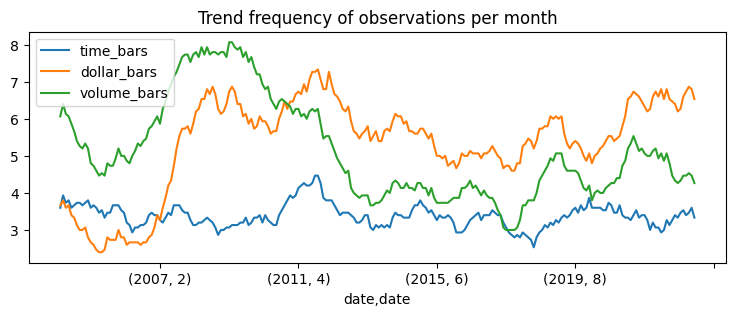

In [46]:
time_bars_price = time_bars_ohlc.loc[:, "close"]
time_bars_ret = np.log(time_bars_price.close / time_bars_price.close.shift(1)).dropna()

dollar_bars_price = dollar_bars_ohlc.loc[:, "close"]
dollar_bars_ret = np.log(
    dollar_bars_price.close / dollar_bars_price.close.shift(1)
).dropna()

volume_bars_price = volume_bars_ohlc.loc[:, "close"]
volume_bars_ret = np.log(
    volume_bars_price.close / volume_bars_price.close.shift(1)
).dropna()

info_freq = pd.DataFrame(
    index=data.index,
    data={
        "time_bars": time_bars_ret,
        "dollar_bars": dollar_bars_ret,
        "volume_bars": volume_bars_ret,
    },
)

info_freq = (info_freq > 0).astype(int)

# aggregate by year and month
info_freq.groupby(
    [info_freq.index.year, info_freq.index.month],
).agg("sum").rolling(
    15
).mean().plot(figsize=(9, 3), title="Trend frequency of observations per month")

The previous plot shows the aggregated data on months for each aggregation technique.
An observation on these plots are that the volume bars vary more than the other bars,
nonetheless, the dollar bars tend to follow the volume bars. This could be more
investigated, however, it could mean a value change on stock price following the
trend of volume change.

On the following plot, the volatility of the data is evaluated. The volatility is
calculated by the standard deviation of the returns of the data. The returns are
calculated by the difference between the actual adjusted close values from previous
adjusted close values.

#### Density Plot

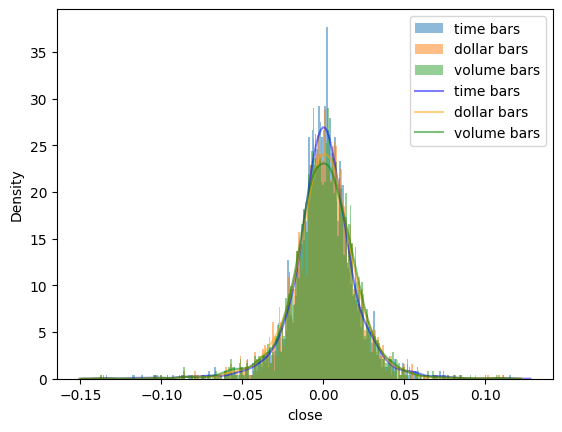

In [47]:
import seaborn as sns

bin_len = 0.001

plt.hist(
    time_bars_ret,
    bins=np.arange(min(time_bars_ret), max(time_bars_ret) + bin_len, bin_len),
    label="time bars",
    alpha=0.5,
    density=True,
)
plt.hist(
    dollar_bars_ret,
    bins=np.arange(min(dollar_bars_ret), max(dollar_bars_ret) + bin_len, bin_len),
    label="dollar bars",
    alpha=0.5,
    density=True,
)
plt.hist(
    volume_bars_ret,
    bins=np.arange(min(volume_bars_ret), max(volume_bars_ret) + bin_len, bin_len),
    label="volume bars",
    alpha=0.5,
    density=True,
)

# kde plot from seaborn
sns.kdeplot(time_bars_ret, label="time bars", color="blue", alpha=0.5)
sns.kdeplot(dollar_bars_ret, label="dollar bars", color="orange", alpha=0.5)
sns.kdeplot(volume_bars_ret, label="volume bars", color="green", alpha=0.5)

plt.legend()

On the plot, it is observed a long tail on the volatility of the data, which is
characteristic of the financial market. Moreover, it is not observed a significant
difference between the volatility of the data, which means that the aggregation
techniques do not affect the volatility of the data for the IBM stocks. Further
investigation should be performed to evaluate, due to the given results are not
conclusive and differs from the expected results. For this reason, time bars will
be used for the following analysis.

### Labeling

Labeling is the process of assigning a label to each observation in the data.
In this tutorial, we will use the following labeling techniques:

- **Triple Barrier Method**: The Triple Barrier Method technique generates labels
based on the price of the stock and the volatility of the stock.
- **Bollinger Bands**: The Bollinger Bands technique generates labels based on
the price of the stock and the Bollinger Bands.
- **MADC**: The MADC technique generates labels based on the price of the stock
and the MADC.

#### Triple Barrier Method (TBM)


Labeling in Finance generally labels observation using the fixed-time horizon 
method [[5]](#5). 

However, this method is not suitable for all cases, due to the fact of time bars
not exhibiting good statistical properties

An approach to mitigate this problem is the triple barrier labeling, which is a
method that labels observations based on the first barrier reached. 

For the fixed horizontal method, considers $X$ as a feature matrix with $m$ rows,
${X_i}_{i=1,\cdots,m}$, drawn from some bars with index $t=1,\cdots,T$, where
$m \leq T$. The triple barrier method labels the $i$-th observation as $y_i$
according to the following rule:

$$
    y_{i} = \begin{cases}
        1 & \text{if } {R_{{t}_{i,0},{t}_{i,0+h}}} > v \\
        0 & \text{if } \vert {R_{{t}_{i,0},{t}_{i,0+h}}} \vert \leq v \\
        -1 & \text{if } {R_{{t}_{i,0},{t}_{i,0+h}}} < -v
  \end{cases}
$$

where $R_{{t}_{i,0},{t}_{i,0+h}}$ is the return from the observation $i$, which
$R_{{t}_{i,0},{t}_{i,0+h}} = \frac{P_{t_{i,0+h}}-P_{t_{i,0}}}{P_{t_{i,0}}}$,
where $P_{t_{i,0}}$ is the price at time $t_{i,0}$, and $v$ is the predefined
threshold constant.

In figure (a), we can see that the lower horizontal barrier is first reached, a $-1$
value is returned. In figure (b) the path never reaches the horizontal and triggers
a $0$ label when the vertical barrier is reached [[6]](#6).

<!-- ![triple_barrier](../images/triple_barrier.png){width=50%} -->

To implement the TBM, the following steps are performed:

- Compute the dynamic thresholds for the upper and lower barriers.

- Determine a signal/trigger for initializing the TBM.

- Add vertical barriers based on trigger times.

- Determine the time of the first touch for each trigger.

- Apply the labels for side and size of the bet.

##### **Determining Daily Volatility**

The first step to implement the TBM is to determine the daily volatility of the
data. The daily volatility is calculated by the standard deviation of the exponential
weighted moving average of the returns of the data.

For this evaluation, it has been considered a span of 50 days.

In [48]:
stock_df = pd.DataFrame({"close": close})

span0 = 50
daily_vol = np.log(stock_df.close).diff().dropna().ewm(span=span0).std()

Plotting the daily volatility, we can see that the volatility is not constant over time.

<Axes: title={'center': 'IBM Daily Exponentially Weighted Moving Standard Deviation'}, xlabel='Date', ylabel='Volatility'>

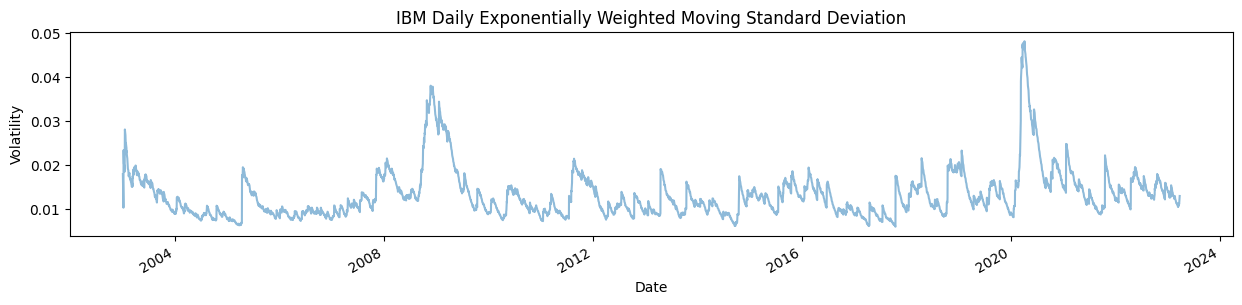

In [49]:
pd.DataFrame(daily_vol).plot(
    figsize=(15, 3),
    title="IBM Daily Exponentially Weighted Moving Standard Deviation",
    xlabel="Date",
    ylabel="Volatility",
    alpha=0.5,
    legend=False,
)

##### **Determine a signal/trigger for initializing the TBM**

The second step is to determine a signal/trigger for initializing the TBM. An approach
is the Symmetric CUSUM Filter, which detects a shift in the mean value of a measured
quantity away from a target value [[7]](#7). It do not considers a fixed time range,
but instead, it considers a dynamic shift in the mean value over a target threashold as
a trigger. For example, if our average volatility is 1%, once we exceed a 1% net
change since our last event, we would generate a new event and reset our
filter [[7]](#7).

For this evaluation, it has been considered as threshold the mean value of exponential
weighted return.

In [50]:
from fico.triplebarriers import get_t_events

threshold = daily_vol.mean() * 1
cusum_events = get_t_events(stock_df.close, threshold=threshold)

Plotting the cusum events, we can see that the events are triggered when the volatility
exceeds the threshold.

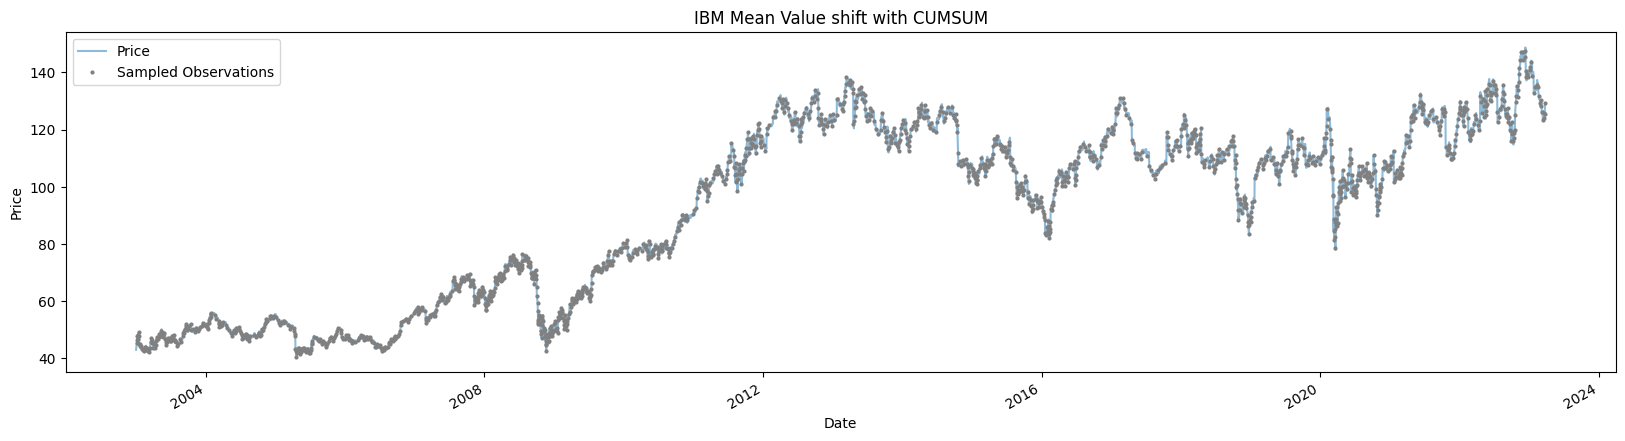

In [51]:
stock_df.close.plot(
    figsize=(20, 5),
    legend=True,
    title="IBM Mean Value shift with CUMSUM",
    xlabel="Date",
    ylabel="Price",
    label="Price",
    alpha=0.5,
)
plt.plot(
    stock_df.close.loc[cusum_events].index,
    stock_df.close[cusum_events],
    "o",
    markersize=2,
    color="grey",
    label="Sampled Observations",
)
plt.legend()

##### **Add vertical barriers based on trigger times**

The third step is to add vertical barriers based on trigger times. The vertical
barriers considers a given time range after the trigger time. 

For this evaluation, the cusum events are considered as triggers witha a time
range of 5 days.

In [52]:
from fico.triplebarriers import add_vertical_barrier

vertical_barriers = add_vertical_barrier(t_events=cusum_events, close=close, num_days=5)
pd.DataFrame(vertical_barriers)

,date
2003-01-03,2003-01-08
2003-01-06,2003-01-13
2003-01-07,2003-01-13
2003-01-08,2003-01-13
2003-01-09,2003-01-14
...,...
2023-03-07,2023-03-13
2023-03-09,2023-03-14
2023-03-15,2023-03-20
2023-03-20,2023-03-27


##### **Determine the time of the first touch for each trigger**

The fourth step is to determine the time of the first touch for each trigger, in 
which, the action would be profit taking or stop loss on the first touch of the
triple barrier. The output of this step is a dataframe with the time of the first
touch and the target volatility as a size of the bet.

In [53]:
from fico.triplebarriers import get_events

pt_sl = np.array([1, 1])  # setting profit-take and stop-loss at 1 and 2 std
min_ret = 0.005  # setting a minimum return of 0.05%

triple_barrier_events = get_events(
    close=stock_df.close,
    t_events=cusum_events,
    pt_sl=pt_sl,
    target=daily_vol,
    min_ret=min_ret,
    vertical_barriers=vertical_barriers,
)
triple_barrier_events

,t1,trgt
2003-01-03,2003-01-06,0.018014
2003-01-06,2003-01-07,0.012677
2003-01-07,2003-01-08,0.010379
2003-01-08,2003-01-09,0.023456
2003-01-09,2003-01-14,0.022007
...,...,...
2023-03-15,2023-03-16,0.010597
2023-03-20,2023-03-22,0.011161
2023-03-22,2023-03-27,0.011400
2023-03-24,2023-03-27,0.011514


##### **Apply the labels for side and size of the bet**

With the events of the triple barrier, it can be applied the labels for side and size
of the bet. The side of the bet is the direction of the bet, which can be long,
short or neutral as signals $1$, $-1$ and $0$, respectively. The size of the bet can be
considered the return of on the first touch of the triple barrier, which can be
considered as the profit taking or stop loss, by taking all the bet for the return.

In [54]:
from fico.triplebarriers import get_bins

labels = get_bins(triple_barrier_events, stock_df.close)
labels.bin = np.where(labels.bin == 1, 1.0, 0.0)
labels.bin.value_counts()

bin
1.0    942
0.0    803
Name: count, dtype: int64

In [55]:
labels.head()

,ret,bin
2003-01-03,0.023873,1.0
2003-01-06,0.028713,1.0
2003-01-07,-0.020986,0.0
2003-01-08,0.033441,1.0
2003-01-09,0.018046,1.0


#### Bollinger Bands

The Bollinger Bands strategy is a mean-reversion strategy that uses the
Bollinger Bands indicator to generate signals. The Bollinger Bands indicator
consists of a middle SMA line and two outer bands, which are the standard
deviation of the SMA. The strategy is based on the assumption that the price
will return to the mean, which is the middle SMA line. The strategy is
implemented as follows[[6]](#6):

The signals are long and short, long when the price touches the lower band
and short when the price touches the upper band.

In [56]:
from fico.technicalindicators import bollingerbandssignal

bollinger_df = bollingerbandssignal(close, window=50, no_of_stdev=2)
bollinger_df.head()

,close,ewm_mean,upper,lower,label,side_long,side_short,side
date,,,,,,,,
2002-12-31,42.94,42.940000,NaN,NaN,NaN,NaN,NaN,-1.0
2003-01-02,44.64,43.807000,46.211163,41.402837,NaN,NaN,NaN,-1.0
2003-01-03,45.24,44.303898,46.675516,41.932280,NaN,NaN,NaN,-1.0
2003-01-06,46.32,44.838560,47.649506,42.027614,NaN,NaN,NaN,-1.0
2003-01-07,47.65,45.446712,48.983805,41.909619,NaN,NaN,NaN,-1.0


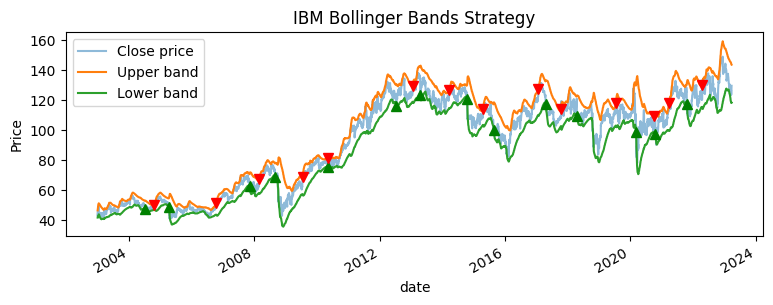

In [57]:
bollinger_df.close.plot(
    figsize=(9, 3),
    legend=True,
    title="IBM Bollinger Bands Strategy",
    xlabel="Date",
    ylabel="Price",
    label="Close price",
    alpha=0.5,
)

bollinger_df.upper.plot(legend=True, label="Upper band")
bollinger_df.lower.plot(legend=True, label="Lower band")


# arrows signals
plt.plot(
    bollinger_df.loc[bollinger_df.side_long == 1].index,
    bollinger_df.lower[bollinger_df.side_long == 1],
    "^",
    markersize=7,
    color="g",
)
plt.plot(
    bollinger_df.loc[bollinger_df.side_short == 1].index,
    bollinger_df.upper[bollinger_df.side_short == 1],
    "v",
    markersize=7,
    color="r",
)

#### Trend Following Strategy

The trend following strategy concerns the idea of two moving averages, with different
time windows, and when the short moving average crosses the long moving average, it is
a signal to buy, and when the short moving average crosses the long moving average,
it is a signal to sell [[6]](#6).

As example, a slow 200 days moving average and a fast 50 days moving average can be
used. When the fast moving average crosses the slow moving average from below, it
is a signal $(1)$ of buying the position, and when the fast moving average crosses
the slow moving average from above, it is a signal of $(-1)$ of selling the
position [[6]](#6).

In [58]:
from fico.technicalindicators import trendfollowsignal

trend_df = trendfollowsignal(close, 50, 200)
trend_df.head()

,close,fast,slow,label,side_short,side_long,side
date,,,,,,,
2002-12-31,42.94,42.940000,42.940000,NaN,NaN,NaN,1.0
2003-01-02,44.64,43.807000,43.794250,1.0,NaN,1.0,1.0
2003-01-03,45.24,44.303898,44.280994,0.0,NaN,NaN,1.0
2003-01-06,46.32,44.838560,44.798417,0.0,NaN,NaN,1.0
2003-01-07,47.65,45.446712,45.380197,0.0,NaN,NaN,1.0


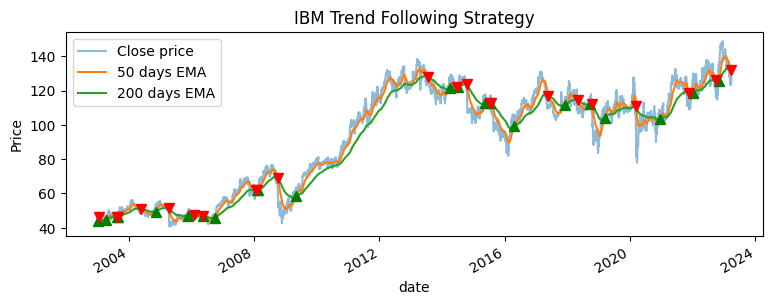

In [59]:
trend_df.close.plot(
    figsize=(9, 3),
    legend=True,
    title="IBM Trend Following Strategy",
    xlabel="Date",
    ylabel="Price",
    label="Close price",
    alpha=0.5,
)

trend_df.fast.plot(legend=True, label="50 days EMA")
trend_df.slow.plot(legend=True, label="200 days EMA")


plt.plot(
    trend_df.side_long.loc[trend_df.side_long == 1].index,
    trend_df.fast.loc[trend_df.side_long == 1],
    "^",
    markersize=7,
    color="g",
)

plt.plot(
    trend_df.side_short.loc[trend_df.side_short == 1].index,
    trend_df.slow.loc[trend_df.side_short == 1],
    "v",
    markersize=7,
    color="r",
)

## Meta-Labeling

Meta-labeling build a secondary ML model that learns how to use a primary
exogenous model [[5]](#5), in order to accept or reject the bet of the primary
model. Therefore, it can assign the side from other strategies, rather than
just THM, and learn only the size of the bet on this meta-labeling model.

Now the possible values for labels are ${0,1}$, as opposed to the previous feasible
values ${−1,0,1}$. The ML algorithm will be trained to decide whether to take the
bet or pass, a purely binary prediction. When the predicted label is $1$, it can be
used the probability of this secondary prediction to derive the size of the bet,
where the side (sign) of the position has been set by the primary model [[5]](#5).

![meta-labeling](../images/meta_labeling.png)

On the first step, an evaluation on Receiver Operating Characteristic (ROC) curve is
performed to find the best threshold to filter the primary model signals with maximum
acceptable recall. Then, the secondary model is trained with the prediction of the
primary model to ensure that the precision of the primary model is maximized and
as consequence maximize the f-1 score.

To implement the meta-labeling, the following steps are performed:

- On the sequence of feature engineering, get the side of the bet. It can considers
    exoegnous models, such as Bollinger Bands and Trend Following Strategy added on 
    features.

- Evaluate the ROC curve to find the best threshold with maximum acceptable recall
    for the primary model.

- Concatenate the predictions of the primary model with the features.

- Evaluate the precision of the secondary model to maximize the f-1 score.


### Meta-Labeling Implementation for THM

#### Side of the Bet

The side of the bet is the direction of the bet, which can be long, short or neutral
as signals $1$, $-1$ and $0$, respectively. On this implementation, the side of the
bet is considered as the signal of the THM, which considers only long signals as 
$1$ and $0$ otherwise.

In [60]:
pt_sl = np.array([1, 2])  # setting profit-take and stop-loss at 1 and 2 std
min_ret = 0.0005  # setting a minimum return of 0.05%

TBM_mlabel = get_events(
    close=stock_df.close,
    t_events=cusum_events,
    pt_sl=pt_sl,
    target=daily_vol,
    min_ret=min_ret,
    vertical_barriers=vertical_barriers,
    side=trend_df.side,
)
# TBM_mlabel

labels = get_bins(TBM_mlabel, stock_df.close)
labels.bin = np.where(labels.bin == 1, 1.0, 0.0)
labels.bin.value_counts()

bin
1.0    942
0.0    803
Name: count, dtype: int64

#### Primary Model Evaluation

The primary model is the THM, which is evaluated on the ROC curve to find the best
threshold with maximum acceptable recall. The ROC curve is a plot of the true positive
rate (TPR) against the false positive rate (FPR) for the different possible values of
the threshold [[6]](#6). The TPR is the ratio of the number of correctly identified
positive examples divided by the total number of positive examples, and the FPR is the
ratio of the number of incorrectly identified negative examples divided by the total
number of negative examples [[6]](#6).

To process the evaluation and avoid data leakage, a validation set is used. The
is out of the training set and used for backtesting. The training is split into
train and test sets using a cross-validation approach for time series data, the Gap
k-fold cross-validation [[8]](#8).

##### Splitting the Data

In [61]:
from sklearn.model_selection import train_test_split

# Get features at event dates
# x = data.loc[labels.index, :].iloc[:,:-1]
df = pd.concat(
    [
        data.loc[labels.index, :].iloc[:, :-1],
        trend_df.loc[labels.index, ["fast", "slow", "side"]],
    ],
    axis=1,
)
x = df
y = labels["bin"]

# Split data
x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.2, shuffle=False)

x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((1396, 9), (1396,), (349, 9), (349,))

##### Cross-Validation Gap K-Fold

The cross-validation is a technique to evaluate the performance of a model. The 
cross-validation is performed by splitting the data into $k$ folds, where $k-1$ folds
are used for training and $1$ fold is used for testing. This process is repeated $k$
times, where each fold is used for testing once [[6]](#6).

The cross-validation gap k-fold, or, blocked k-fold cross-validation, is a technique
to evaluate the performance of a model, which is similar to the cross-validation,
with the intention of avoiding the leakage of information due to the time series
nature of the data [[8]](#8). The cross-validation gap k-fold is performed by splitting
the data into $k$ folds, where $k-b-a$ folds are used for training and $a$ folds after
the testing fold are blocked, and $b$ folds before the testing fold are blocked. This
process is repeated $k$ times, where each fold is used for testing once [[8]](#8).


![cross_validation](../images/cross_validation.png){width=50%}

In [62]:
from fico.utils import gap_kfold

# split train and test with gap before and after the test
gap_before = 2
gap_after = 1
kfold = 13

test_position = 7
x_train, y_train, x_test, y_test = gap_kfold(
    x_tr, y_tr, kfold, test_position, gap_before, gap_after
)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((963, 9), (963,), (107, 9), (107,))

##### Primary Forecast

Evaluating the data with a zero threshold, which means that all the signals are
considered as $1$, it is possible to see that the recall is $100\%$, which means that
all the positive examples are correctly identified. However, the precision is $54\%$,
which means that half of the positive examples are incorrectly identified.

In [63]:
from fico.utils import modelmetrics

accuracy_ck, precision_ck, recall_ck, f1_score_ck, threashold_ck = modelmetrics(
    x_train, y_train, plot=False
)

print(
    f"Accuracy: {accuracy_ck:.2f},\
    Precision: {precision_ck:.2f},\
    Recall: {recall_ck:.2f},\
    F1 Score: {f1_score_ck:.2f},\
    Threashold: 0\
    "
)

Accuracy: 0.54,    Precision: 0.54,    Recall: 1.00,    F1 Score: 0.70,    Threashold: 0    


##### ROC Curve for Primary Model

To improve the precision of the primary model, it is possible to use the ROC curve to
find the best threshold with maximum acceptable recall. The ROC curve is a plot of the
true positive rate (TPR) against the false positive rate (FPR) for the different
possible values of the threshold [[6]](#6). 

In [64]:
from sklearn.ensemble import RandomForestClassifier

# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

rf = RandomForestClassifier(
    max_depth=depth,
    n_estimators=n_estimator,
    criterion="entropy",
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE,
)

# Fitting our model
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

Fiding the best threshold with maximum acceptable recall:

              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06       447
         1.0       0.54      1.00      0.70       516

    accuracy                           0.55       963
   macro avg       0.77      0.52      0.38       963
weighted avg       0.76      0.55      0.41       963

Accuracy
0.5503634475597092


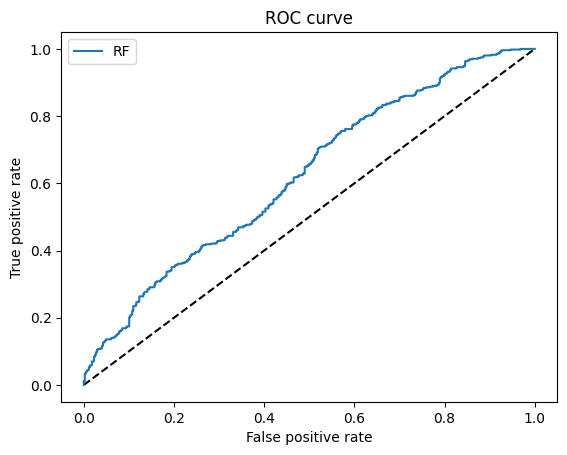

Accuracy: 0.55,    Precision: 0.54,    Recall: 1.00,    F1 Score: 0.70,    Threashold: 0.32


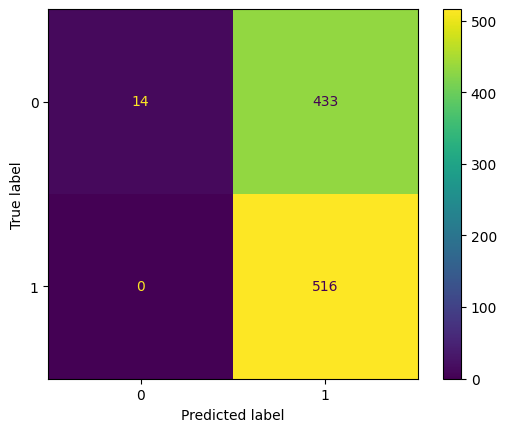

In [65]:
accuracy_tr1, precision_tr1, recall_tr1, f1_score_tr1, threashold_tr1 = modelmetrics(
    x_train, y_train, rf, True, None, True
)

print(
    f"Accuracy: {accuracy_tr1:.2f},\
    Precision: {precision_tr1:.2f},\
    Recall: {recall_tr1:.2f},\
    F1 Score: {f1_score_tr1:.2f},\
    Threashold: {threashold_tr1:.2f}"
)

Plotting the ROC curve:

              precision    recall  f1-score   support

         1.0       0.62      1.00      0.76        66

   micro avg       0.62      1.00      0.76        66
   macro avg       0.62      1.00      0.76        66
weighted avg       0.62      1.00      0.76        66

Accuracy
0.616822429906542


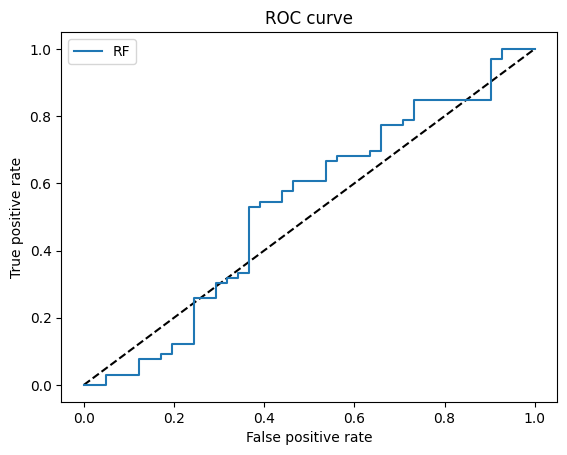

Accuracy: 0.62,    Precision: 0.62,    Recall: 1.00,    F1 Score: 0.76,    Threashold: 0.32


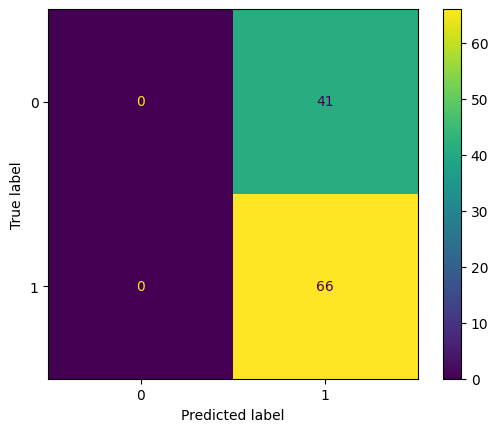

In [66]:
accuracy_tt1, precision_tt1, recall_tt1, f1_score_tt1, threashold_tt1 = modelmetrics(
    x_test,
    y_test,
    rf,
    False,
    threashold_tr1,
    True,
)

print(
    f"Accuracy: {accuracy_tt1:.2f},\
    Precision: {precision_tt1:.2f},\
    Recall: {recall_tt1:.2f},\
    F1 Score: {f1_score_tt1:.2f},\
    Threashold: {threashold_tt1:.2f}"
)

#### Concatene the Predictions of the Primary Model with the Features

The predictions of the primary model are concatenated with the features.

In [67]:
# concatenating predicted probabilities to the original values
x_pred_tr = rf.predict_proba(x_train)[:, 1]
x_train_2 = np.concatenate((x_train, x_pred_tr.reshape(-1, 1)), axis=1)
x_train_2.shape

x_pred_tt = rf.predict_proba(x_test)[:, 1]
x_test_2 = np.concatenate((x_test, x_pred_tt.reshape(-1, 1)), axis=1)
x_test_2.shape

(107, 10)

In [68]:
x_train_2.shape, x_test_2.shape

((963, 10), (107, 10))

### Secondary Model

Building the secondary model:

In [69]:
rf_2 = RandomForestClassifier(
    max_depth=depth,
    n_estimators=n_estimator,
    criterion="entropy",
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE,
)

# Fitting our model
rf_2.fit(x_train_2, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

Checking the precision of the secondary model:

              precision    recall  f1-score   support

         0.0       0.61      0.44      0.51       447
         1.0       0.61      0.76      0.67       516

    accuracy                           0.61       963
   macro avg       0.61      0.60      0.59       963
weighted avg       0.61      0.61      0.60       963

Accuracy
0.6074766355140186


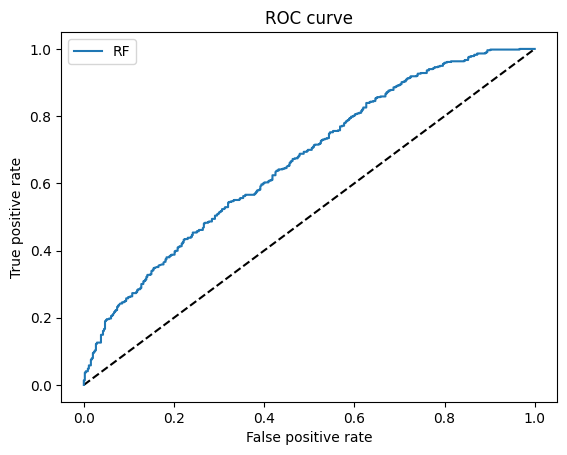

Accuracy: 0.61,    Precision: 0.61,    Recall: 0.76,    F1 Score: 0.67,    Threashold: 0.50


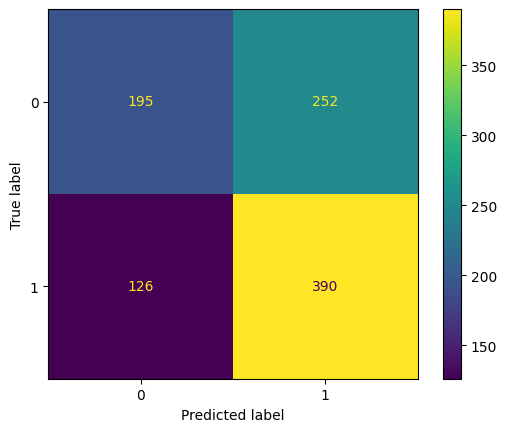

In [70]:
accuracy_tr2, precision_tr2, recall_tr2, f1_score_tr2, threashold_tr2 = modelmetrics(
    x_train_2,
    y_train,
    rf_2,
    False,
    None,
    True,
)

print(
    f"Accuracy: {accuracy_tr2:.2f},\
    Precision: {precision_tr2:.2f},\
    Recall: {recall_tr2:.2f},\
    F1 Score: {f1_score_tr2:.2f},\
    Threashold: {threashold_tr2:.2f}"
)

              precision    recall  f1-score   support

         0.0       0.38      0.68      0.49        41
         1.0       0.62      0.32      0.42        66

    accuracy                           0.46       107
   macro avg       0.50      0.50      0.46       107
weighted avg       0.53      0.46      0.45       107

Accuracy
0.45794392523364486


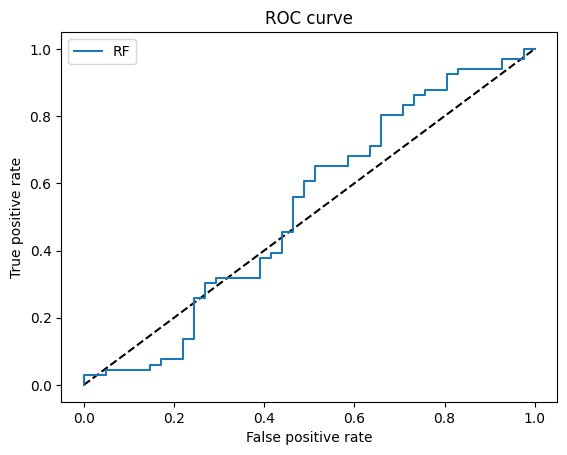

Accuracy: 0.46,    Precision: 0.62,    Recall: 0.32,    F1 Score: 0.42,    Threashold: 0.50


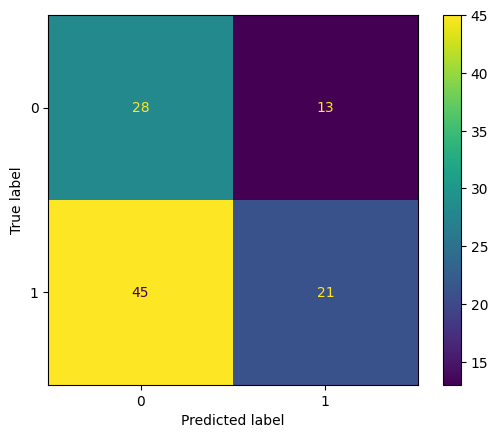

In [71]:
accuracy_tt2, precision_tt2, recall_tt2, f1_score_tt2, threashold_tt2 = modelmetrics(
    x_test_2,
    y_test,
    rf_2,
    False,
    None,
    True,
)

print(
    f"Accuracy: {accuracy_tt2:.2f},\
    Precision: {precision_tt2:.2f},\
    Recall: {recall_tt2:.2f},\
    F1 Score: {f1_score_tt2:.2f},\
    Threashold: {threashold_tt2:.2f}"
)

### Full pipeline with cross-validation:

In [72]:
from fico.metalabeling import metalabelingkfold

# Parameters

# THM parameters
pt_sl = np.array([1, 1])  # setting profit-take and stop-loss at 1 and 2 std
min_ret = 0.0005  # setting a minimum return of 0.05%

# train test split parameters
test_size = 0.2

# gap kfold parameters
gap_before = 2
gap_after = 1
kfold = 13

# Random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

dfs_thm = {
    "sampling_bars": data,
    "cusum_events": cusum_events,
    "close": stock_df.close,
    "daily_vol": daily_vol,
    "vertical_barriers": vertical_barriers,
    # "df_exogenous": bollinger_df,
}

params = {
    "pt_sl": pt_sl,
    "min_ret": min_ret,
    "test_size": test_size,
    "gap_before": gap_before,
    "gap_after": gap_after,
    "kfold": kfold,
    "n_estimator": n_estimator,
    "depth": depth,
}


result = metalabelingkfold(dfs_thm, params)

In [73]:
dfs_bb = {
    "sampling_bars": data,
    "cusum_events": cusum_events,
    "close": stock_df.close,
    "daily_vol": daily_vol,
    "vertical_barriers": vertical_barriers,
    "df_exogenous": bollinger_df,
}

result_bb = metalabelingkfold(dfs_bb, params, "bollinger_bands")

In [74]:
dfs_tt = {
    "sampling_bars": data,
    "cusum_events": cusum_events,
    "close": stock_df.close,
    "daily_vol": daily_vol,
    "vertical_barriers": vertical_barriers,
    "df_exogenous": trend_df,
}


result_tf = metalabelingkfold(dfs_tt, params, "trend_following")

array([<Axes: title={'center': 'f1_score_tt1'}, xlabel='exogenous'>,
       <Axes: title={'center': 'f1_score_tt2'}, xlabel='exogenous'>],
      dtype=object)

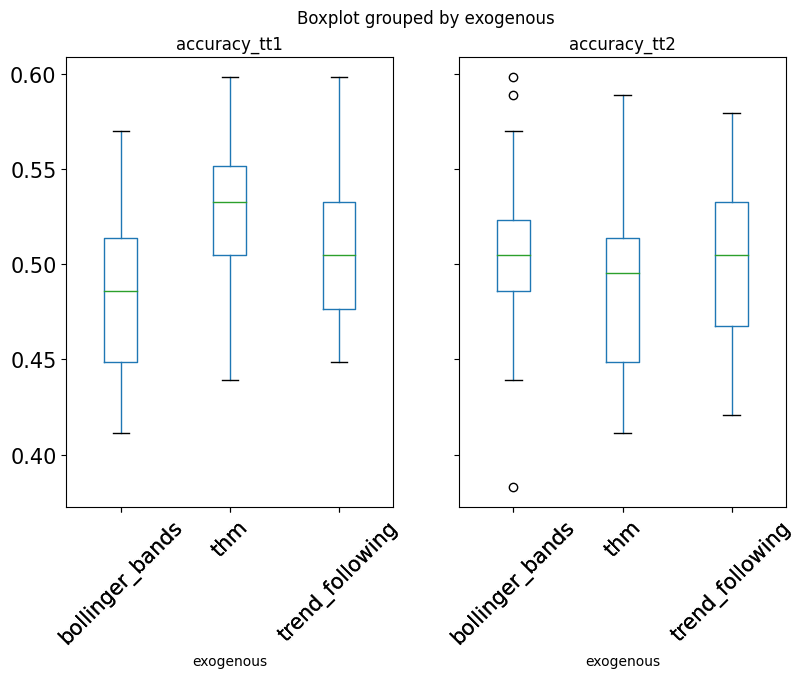

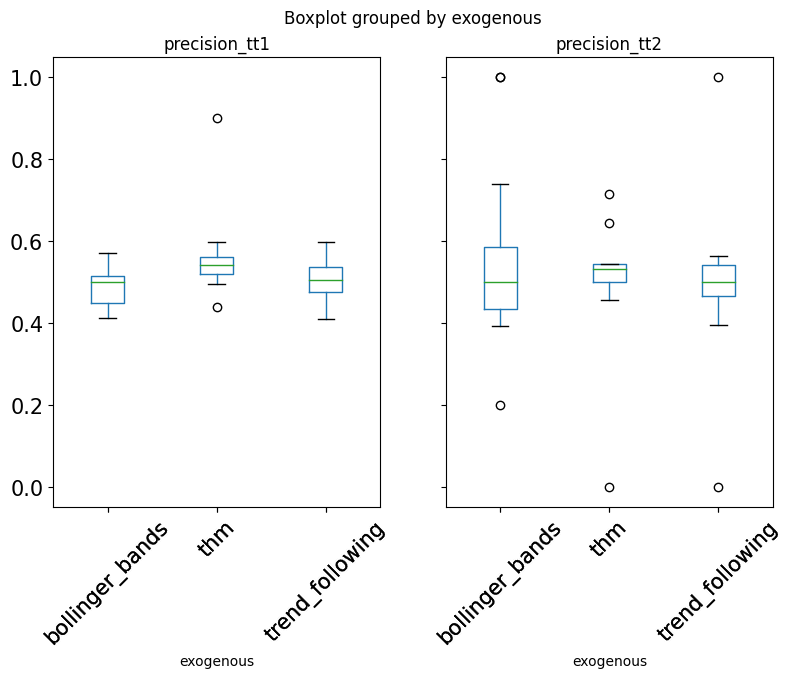

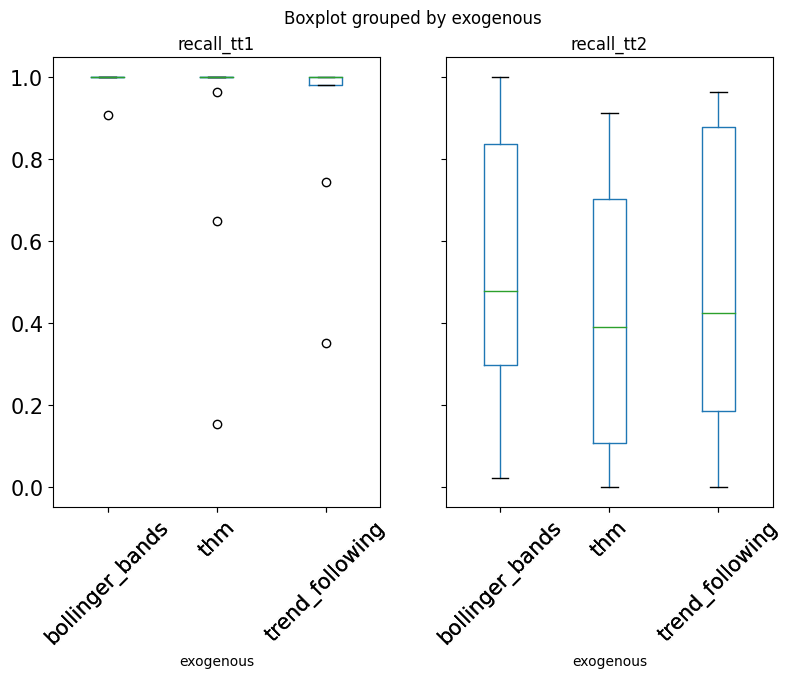

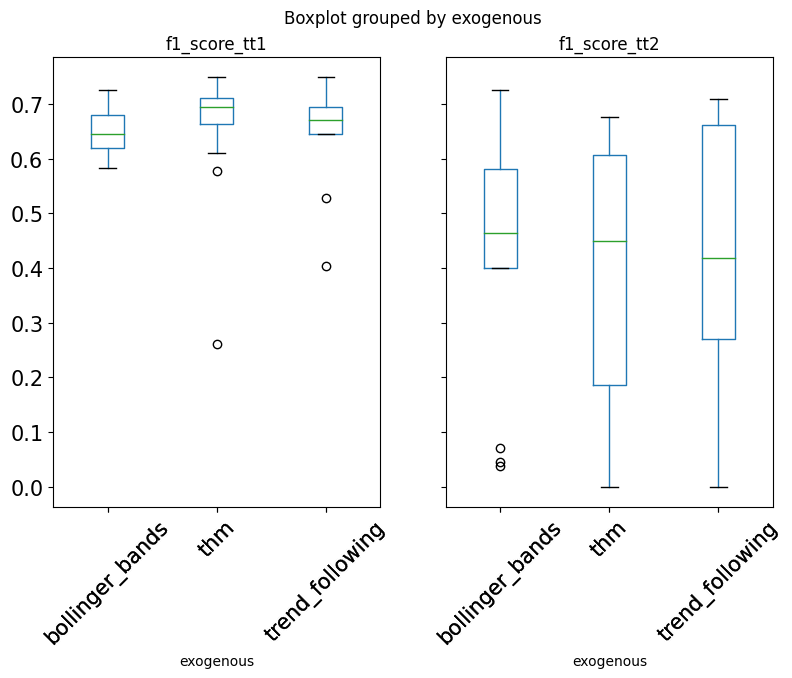

In [83]:
# concatenate all results
results = pd.concat([result, result_bb, result_tf], axis=0)
results.loc[results.exogenous.isnull(), "exogenous"] = "thm"
results.groupby("exogenous").mean()
results.groupby("exogenous").std()

# plot boxplot accuracy_tt2, precision_tt2 per exogenous
results.boxplot(
    column=["accuracy_tt1", "accuracy_tt2"],
    by="exogenous",
    figsize=(9, 6),
    layout=(1, 2),
    grid=False,
    fontsize=15,
    rot=45,
)

results.boxplot(
    column=["precision_tt1", "precision_tt2"],
    by="exogenous",
    figsize=(9, 6),
    layout=(1, 2),
    grid=False,
    fontsize=15,
    rot=45,
)

results.boxplot(
    column=["recall_tt1", "recall_tt2"],
    by="exogenous",
    figsize=(9, 6),
    layout=(1, 2),
    grid=False,
    fontsize=15,
    rot=45,
)

results.boxplot(
    column=["f1_score_tt1", "f1_score_tt2"],
    by="exogenous",
    figsize=(9, 6),
    layout=(1, 2),
    grid=False,
    fontsize=15,
    rot=45,
)

## Backtesting

Backtesting is a technique to evaluate the performance of a model, which validates the
model on historical data [[6]](#6). The backtesting is performed on the validation set,
which is out of the training set. On financial markets, the backtesting is performed
by simulating the trading strategy on historical data, which is called paper trading
[[6]](#6). On this implementation, financial metrics are used to evaluate the
performance of the model, such as the Sharpe ratio, which is the average return
earned in excess of the risk-free rate per unit of volatility or total risk [[6]](#6),
the annual return, which is the percentage of return on the initial investment [[6]](#6),
 the cummulatve return, which is the total return on the initial investment [[6]](#6), 
 the maximum drawdown, which is the maximum loss from a peak to a trough of a portfolio
 [[6]](#6), and the annual volatility, which is the standard deviation of the daily
 returns [[6]](#6).

,mean_return,std_return,sharpe_ratio,max_drawdown
No Exogenous,0.016538,0.171699,1.529075,-0.077917
Bollinger Bands,0.013372,0.372708,0.569547,-0.180483
Trend Following,0.013372,0.372708,0.569547,-0.180483


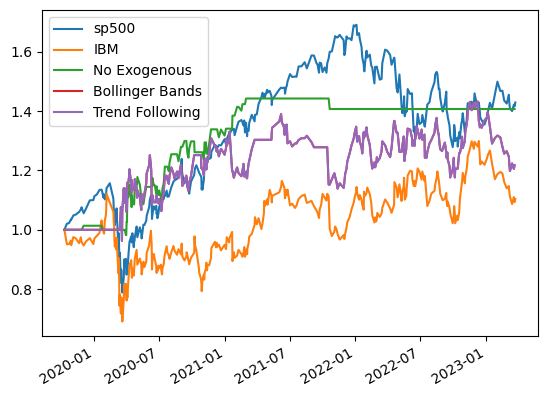

In [84]:
from fico.metalabeling import metalabelingval

model_thm, x_train_thm, _, x_val_thm, _, features_thm = metalabelingval(dfs_thm, params)
model_bb, x_train_bb, _, x_val_bb, _, features_bb = metalabelingval(
    dfs_bb, params, "bollinger_bands"
)
model_tt, x_train_tt, _, x_val_tt, _, features_tt = metalabelingval(
    dfs_tt, params, "trend_following"
)

ts_idx_thm = features_thm.index[features_thm.index > x_train_thm.index[-1]]
ts_idx_bb = features_bb.index[features_bb.index > x_train_bb.index[-1]]
ts_idx_tt = features_tt.index[features_tt.index > x_train_tt.index[-1]]

# benchmark
sp500 = pd.read_csv(f"../../data/sp500.csv")
sp500["date"] = pd.to_datetime(sp500["date"])
sp500.set_index("date", inplace=True)
cum_return_sp500 = sp500.adj_close[ts_idx_thm] / (sp500.adj_close[ts_idx_thm].iloc[0])

# stock cum sum
cum_return_stock = stock_df.close[ts_idx_thm] / (stock_df.close[ts_idx_thm].iloc[0])


col_thm = x_train_thm.columns.to_list()
col_bb = x_train_bb.columns.to_list()
col_tt = x_train_tt.columns.to_list()
col_thm.append("predict_m1")
col_bb.append("predict_m1")
col_tt.append("predict_m1")


res_thm = pd.DataFrame(x_val_thm, columns=col_thm, index=ts_idx_thm)
res_bb = pd.DataFrame(x_val_bb, columns=col_bb, index=ts_idx_bb)
res_tt = pd.DataFrame(x_val_tt, columns=col_tt, index=ts_idx_tt)


pred_thm = model_thm.predict(x_val_thm)
pred_bb = model_bb.predict(x_val_bb)
pred_tt = model_tt.predict(x_val_tt)


cum_ret_thm = (
    ((res_thm.adj_close.pct_change().shift(-1) * pred_thm) + 1).cumprod().dropna()
)
cum_ret_bb = (
    ((res_bb.adj_close.pct_change().shift(-1) * pred_bb) + 1).cumprod().dropna()
)
cum_ret_tt = (
    ((res_tt.adj_close.pct_change().shift(-1) * pred_bb) + 1).cumprod().dropna()
)


mean_return_thm = cum_ret_thm.pct_change().mean() * np.sqrt(252)
mean_return_bb = cum_ret_bb.pct_change().mean() * np.sqrt(252)
mean_return_tt = cum_ret_tt.pct_change().mean() * np.sqrt(252)


std_return_thm = cum_ret_thm.pct_change().std() * np.sqrt(252)
std_return_bb = cum_ret_bb.pct_change().std() * np.sqrt(252)
std_return_tt = cum_ret_tt.pct_change().std() * np.sqrt(252)


sharpe_ratio_thm = (mean_return_thm / std_return_thm) * np.sqrt(252)
sharpe_ratio_bb = (mean_return_bb / std_return_bb) * np.sqrt(252)
sharpe_ratio_tt = (mean_return_tt / std_return_tt) * np.sqrt(252)


max_drawdown_thm = cum_ret_thm.div(cum_ret_thm.cummax()).sub(1).min()
max_drawdown_bb = cum_ret_bb.div(cum_ret_bb.cummax()).sub(1).min()
max_drawdown_tt = cum_ret_tt.div(cum_ret_bb.cummax()).sub(1).min()


cum_return_sp500.plot(label="sp500")
cum_return_stock.plot(label="IBM")
cum_ret_thm.plot(label="No Exogenous")
cum_ret_bb.plot(label="Bollinger Bands")
cum_ret_tt.plot(label="Trend Following")

plt.legend()

df_bkprop = pd.DataFrame(
    {
        "mean_return": [mean_return_thm, mean_return_bb, mean_return_tt],
        "std_return": [std_return_thm, std_return_bb, std_return_tt],
        "sharpe_ratio": [sharpe_ratio_thm, sharpe_ratio_bb, sharpe_ratio_tt],
        "max_drawdown": [max_drawdown_thm, max_drawdown_bb, max_drawdown_tt],
    },
    index=["No Exogenous", "Bollinger Bands", "Trend Following"],
)

df_bkprop

## Conclusion

Meta-Labeling is a technique that uses the predictions of a classifier to label the data
 to improve the performance of the classifier. In this work, it has been applied the
 Meta-Labeling technique to the problem of predicting the direction of the next day's
 return of the IBM stock, and evaluate if you take or pass the bet. The results show
 that the Meta-Labeling process has improved the precision rate, which is the objective
 of the process. However, the recall rate has decreased, which means that the model is
 not good for the classification. 

On the backtesting process, it is observed that the strategy with the Meta-Labeling
process outperformed the stock for the TBM. Despite that the others methods has not
shown significant difference between each other on the machine learning metrics. In
addition, the bollinger bands and trend following has presented same results on the
backtesting process.

Moreover, the analysis on the aggregation of time series, and volume of information
has shown the frequency of information can change according to the technique
aggregation of the time series. Dollar and volume aggregation has shown more normality
distribution than the common time bars. 

For future researches, the methods could be improved by using other features as market
data, others machine learning models, or others aggregation techniques, and others
labeling strategies.

## References

<a id="1">[1]</a>
J. Yu, K. Chang, (2020).
Neural Network Predictive Modeling on Dynamic Portfolio Management -
A Simulation-Based Portfolio Optimization Approach.
J. Risk Financial Manag. vol. 13(11), pp. 285.

<a id="2">[2]</a>
Y. Han, J. Kim, D. Enke, (2023)
A machine learning trading system for the stock market based on
N-period Min-Max labeling using XGBoost.
Expert Systems with Applications, v. 211, p. 118581.

<a id="3">[3]</a>
M. Lopez de Prado, (2017).
The 7 reasons most machine learning funds fail (presentation slides).
Social Science Research Network, Rochester, NY, SSRN Scholarly Paper ID, 3197726.

<a id="4">[4]</a>
S. Bounid, M. Oughanem, S. Boukardi, (2022).
Advanced Financial Data Processing and Labeling Methods for Machine Learning.
In: 2022 International Conference on Intelligent Systems and Computer
Vision (ISCV). IEEE. p. 1-6.

<a id="5">[5]</a>
M. Lopez de Prado, (2018).
Advances in financial machine learning. John Wiley & Sons.

<a id="6">[6]</a>
A. Singh, J. Joubert, (2019).
Does meta labeling add to signal efficacy.

<a id="7">[7]</a>
Sefidian, A. M. (2021).
Labeling financial data for Machine Learning. Sefidian Academy.

<a id="8">[8]</a>
Cerqueira, V. (2023). 
9 Techniques for Cross-validating Time Series Data. Vitor Cerqueira, Medium.